# 0.1 Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


## 0.1.1 Loading datasets

In [2]:
raw_df = pd.read_csv('../data/raw/train.csv')

# 1.0 Data description 

## 1.1 Checking dataset shape and columns

In [3]:
raw_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
raw_df.shape

(381109, 12)

In [5]:
raw_df.columns = [col.lower().replace(' ','_') for col in raw_df.columns]

## 1.2 Checking data types

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [7]:

raw_df['region_code'] = raw_df['region_code'].astype('int')
raw_df['policy_sales_channel'] = raw_df['policy_sales_channel'].astype('int')
raw_df['gender'] = raw_df['gender'].astype('category')
raw_df['vehicle_damage'] = raw_df['vehicle_damage'].astype('category')

## 1.3 Checking missing or unsupported data 

<Axes: >

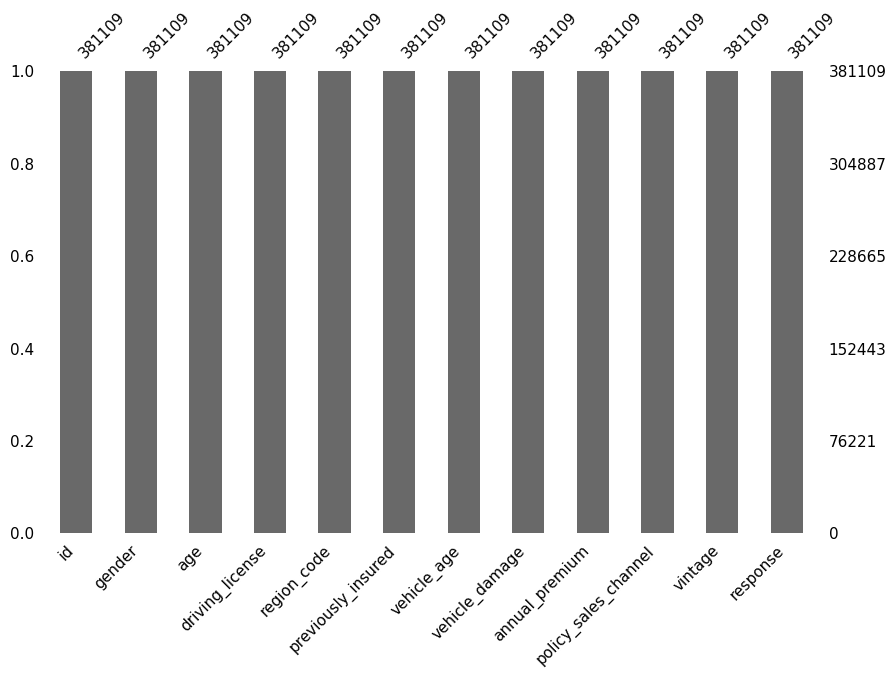

In [8]:
msno.bar(raw_df, figsize=(10,6), fontsize=11)

In [9]:
vehicle_dmg = raw_df['vehicle_damage'].str.count(r'[^a-zA-Z0-9\s]').sum()
gender = raw_df['gender'].astype('str').str.count(r'[^a-zA-Z0-9\s]').sum()

print(f'\'vehicle_damage\' special characters: {vehicle_dmg} \n\'gender\' special characters: {gender}')


'vehicle_damage' special characters: 0 
'gender' special characters: 0


In [10]:
# Adding some labels for better EDA and data explanation
# raw_df['vehicle_age'] = raw_df['vehicle_age'].map({'< 1 Year': 'New',
#                                                    '1-2 Year': 'Nearly New', 
#                                                    '> 2 Years': 'Old'})

# raw_df['driving_license'] = raw_df['driving_license'].map({1: 'Has License',
#                                                            0: 'No License'})

# raw_df['previously_insured'] = raw_df['previously_insured'].map({1: 'Yes',
#                                                                  0: 'No'})

# raw_df['response'] = raw_df['response'].map({1: 'Yes',
#                                              0: 'No'})

# raw_df['vehicle_age'] = raw_df['vehicle_age'].astype('category')
# raw_df['driving_license'] = raw_df['driving_license'].astype('category')
# raw_df['previously_insured'] = raw_df['previously_insured'].astype('category')
# raw_df['response'] = raw_df['response'].astype('category')

# Saving interm dataframe for EDA
# raw_df.to_csv('../data/interim/eda_train.csv', index=False)

## 1.4 Descriptive analysis 

In [11]:
raw_df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0


In [12]:
num_features = raw_df.select_dtypes(include=['int64','float64'])
cat_features = raw_df.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [13]:
kurt_skew = num_features.apply(lambda x: x.agg(['kurtosis', 'skew'])).T
df_describe = num_features.describe().T

df_stats = pd.concat([df_describe, kurt_skew], axis=1)
df_stats  

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,-1.200000,9.443274e-16
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,-0.565655,6.725390e-01
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,464.354302,-2.159518e+01
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-0.867857,-1.152664e-01
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,-1.971871,1.677471e-01
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,34.004569,1.766087e+00
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-0.970810,-9.000081e-01
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,-1.200688,3.029517e-03
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298788,2.301906e+00


---

# 2.0 Feature engineering

In [17]:
raw_df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0


## 2.1 Encoding

In [ ]:
# gender
# driving_license
# region_code
# previously_insured
# vehicle_age
# vehicle_damage


## 2.2 Rescaling

In [ ]:
# age
# vintage

## 2.3 Standartization

In [ ]:
# annual_premium

## 2.4 Feature Selection

In [15]:
df1 = raw_df.drop(['id'], axis=1)

In [16]:
df1.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0
